### Load python modules ###

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas
import pycountry
import seaborn as sns
import collections
import sys
import os

import geoip2.database


import alluvial
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import country_converter
coco = country_converter.CountryConverter()

### Load datasets ###

In [3]:
# data_version = 'old'
data_version = 'all'
raw_data_folder = "../custom-datasets/raw/20250110/results/"

In [3]:
all_cctld_data_path = raw_data_folder + 'all_cctld_ns.csv'

In [8]:
# df = pd.read_csv(all_cctld_data_path, index_col=0, keep_default_na=False)
df = pd.concat([pd.read_csv(raw_data_folder+'/'+fname, index_col=0, keep_default_na=False) for fname in os.listdir(raw_data_folder)
               if fname.endswith('csv')])
df.head()

,cc,dnssec,dnssec_algo,deploy360,ns,authoritative,ip,af,asn4,asn6,region,anycast_provider,anycast_provider_ratio,ip_country,out_region,out_region_4,out_region_6,anycast,anycast_4,anycast_6
0,GQ,False,,False,A.NS.GQ,True,185.21.168.65,4,61005,,ripencc,freenom,freenom,NL,100.0,100.0,100.0,100.0,100.0,100.0
1,GQ,False,,False,A.NS.GQ,True,2a04:1b00:10:0:0:0:0:1,6,61005,61005,ripencc,freenom,"freenom,freenom",NL,100.0,100.0,100.0,100.0,100.0,100.0
2,GQ,False,,False,B.NS.GQ,True,185.21.169.65,4,61005,61005,ripencc,freenom,"freenom,freenom,freenom",NL,100.0,100.0,100.0,100.0,100.0,100.0
3,GQ,False,,False,B.NS.GQ,True,2a04:1b00:11:0:0:0:0:1,6,61005,61005,ripencc,freenom,"freenom,freenom,freenom,freenom",NL,100.0,100.0,100.0,100.0,100.0,100.0
4,GQ,False,,False,C.NS.GQ,True,185.21.170.65,4,61007,61005,ripencc,freenom,"freenom,freenom,freenom,freenom,freenom",NL,100.0,100.0,100.0,100.0,100.0,100.0


# Get IP geo location
Using Maxmind data

In [ ]:
import geoip2.database
import maxminddb

In [6]:
def get_ip_country(reader,ip):
    # with geoip2.database.Reader('GeoLite2-Country_20240820/GeoLite2-Country.mmdb') as reader:
    response = reader.country(ip)
    return response.country.iso_code

reader=geoip2.database.Reader('GeoLite2-Country_20240820/GeoLite2-Country.mmdb')

In [7]:
ip_country = df['ip'].apply(lambda ip:get_ip_country(reader,ip) if ip!='0' else np.nan)

In [8]:
df['ip_country'] = ip_country

## For Blog Post
CRITICAL BEST PRACTICES
- nNSes: >=2
- nIPv4: >=2
- nIPv6: >=2
- nASv4: >=2
- nASv6: >=2
- nGeoDiverseNSes: >=2

RECOMMENDED BEST PRACTICES
- nTLDs: >=2
- nAnycast4: >=1
- nAnycast6: >=1

OTHERS
- nRIRv4: >=2
- nRIRv6: >=2
- nOutRegio4: >=1
- nOutRegio6: >=1

In [9]:
g_df = pd.DataFrame()

In [10]:
nNSes = df.groupby('cc')['ns'].nunique()
nIPv4 = df.query('af == 4').groupby('cc')['ip'].nunique()
nIPv6 = df.query('af == 6').groupby('cc')['ip'].nunique()
nASv4 = df.groupby('cc')['asn4'].nunique()
nASv6 = df.groupby('cc')['asn6'].nunique()

nTLDs = df.assign(ns_tld = lambda df:df['ns'].str.split('.').str[-1]).groupby('cc')['ns_tld'].nunique()
perc_anycast4 = df.groupby('cc')['anycast_4'].first()
perc_anycast6 = df.groupby('cc')['anycast_6'].first()
nAnycast4 = nIPv4*perc_anycast4/100
nAnycast6 = nIPv6*perc_anycast6/100

nRIRv4 = df.query('af == 4').groupby('cc')['region'].nunique()
nRIRv6 = df.query('af == 6').groupby('cc')['region'].nunique()


In [12]:
g_df['nNSes'] = nNSes
g_df['nIPv4'] = nIPv4
g_df['nIPv6'] = nIPv6
g_df['nASv4'] = nASv4
g_df['nASv6'] = nASv6

g_df['nRIRv4'] = nRIRv4
g_df['nRIRv6'] = nRIRv6

g_df['nTLDs'] = nTLDs
g_df['nAnycast4'] = nAnycast4
g_df['nAnycast6'] = nAnycast6



In [11]:
# ip location from maxmind
nGeoDiverseNSes = df.groupby('cc')['ip_country'].nunique()

In [13]:
g_df['nGeoDiverseNSes'] = nGeoDiverseNSes

In [14]:
g_df = g_df.fillna(0).astype(int)
g_df

,nNSes,nIPv4,nIPv6,nASv4,nASv6,nRIRv4,nRIRv6,nTLDs,nAnycast4,nAnycast6,nGeoDiverseNSes
cc,,,,,,,,,,,
AC,4,4,4,3,2,1,1,1,2,0,2
AD,4,4,4,4,5,1,1,3,2,2,3
AE,4,4,4,4,3,3,3,2,2,1,3
AF,3,3,2,3,2,2,2,2,3,2,3
AG,6,6,6,2,3,1,1,2,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...
YE,6,6,6,3,2,2,1,1,0,0,1
YT,4,4,4,4,5,1,1,1,2,1,4
ZA,3,3,2,3,3,3,2,2,1,2,4


In [58]:
g_df.to_csv('../datasets/cctld_metric_value.csv')

In [18]:
# Best practice
best_practice = {
    'nNSes':2, 
    'nIPv4':2, 
    'nIPv6':2, 
    'nASv4':2, 
    'nASv6':2, 
    'nTLDs':2, 
    'nAnycast4':1,
    'nAnycast6':1, 
    'nRIRv4':2, 
    'nRIRv6':2,
    'nGeoDiverseNSes':2,
}

three_scale = pd.CategoricalDtype(['Bad','Good','Better'], ordered=True)


In [19]:
maturity_df = pd.DataFrame()

In [20]:
# define factor to infer 'better', i.e., better if x >= factor*recommendation
n_better = 2

for col in g_df.columns:
    maturity_df[col] = g_df[col].apply(lambda x:
                                       'Bad' if x < best_practice[col]
                                       else 'Better' if x >= n_better * best_practice[col]
                                       else 'Good'
                                      )

maturity_df

,nNSes,nIPv4,nIPv6,nASv4,nASv6,nRIRv4,nRIRv6,nTLDs,nAnycast4,nAnycast6,nGeoDiverseNSes
cc,,,,,,,,,,,
AC,Better,Better,Better,Good,Good,Bad,Bad,Bad,Better,Bad,Good
AD,Better,Better,Better,Better,Better,Bad,Bad,Good,Better,Better,Good
AE,Better,Better,Better,Better,Good,Good,Good,Good,Better,Good,Good
AF,Good,Good,Good,Good,Good,Good,Good,Good,Better,Better,Good
AG,Better,Better,Better,Good,Good,Bad,Bad,Good,Better,Bad,Bad
...,...,...,...,...,...,...,...,...,...,...,...
YE,Better,Better,Better,Good,Good,Good,Bad,Bad,Bad,Bad,Bad
YT,Better,Better,Better,Better,Better,Bad,Bad,Bad,Better,Good,Better
ZA,Good,Good,Good,Good,Good,Good,Good,Good,Good,Better,Better


In [23]:
tableau_color = ['tab:red','tab:orange','tab:green']

cbcolors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
}

threescale_cbcolors=[cbcolors['gray'],cbcolors['blue'],cbcolors['orange']]

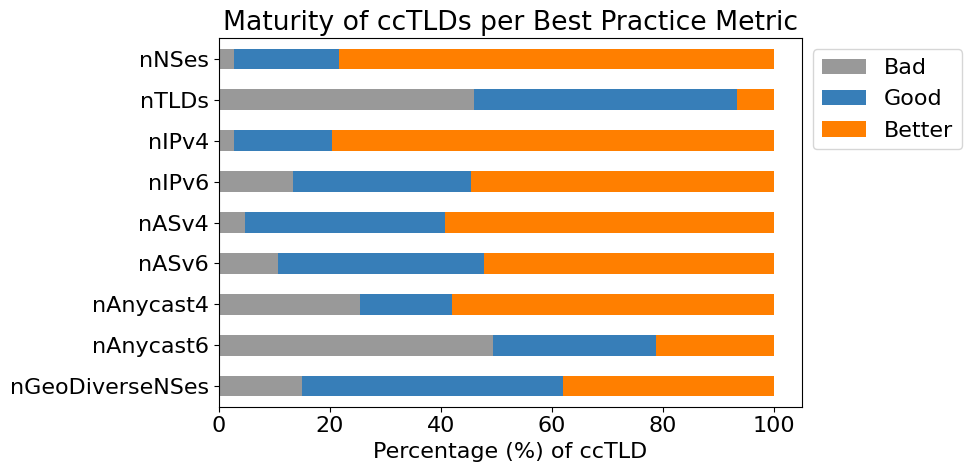

In [29]:
fig,ax=plt.subplots(figsize=(10,5))

plt.rcParams.update({'font.size': 16})

col_order = 'nNSes,nTLDs,nIPv4,nIPv6,nASv4,nASv6,nAnycast4,nAnycast6,nGeoDiverseNSes'.split(',')
col_order = col_order[::-1] # reverse
(
    maturity_df.drop(columns=['nRIRv4','nRIRv6']).astype(three_scale)
    .loc[:,col_order]
    .apply(lambda x:x.value_counts()).T.apply(lambda x:100*x/sum(x),axis=1)
    .plot.barh(color=threescale_cbcolors,stacked=True,ax=ax)
)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Maturity of ccTLDs per Best Practice Metric')
plt.xlabel('Percentage (%) of ccTLD')
plt.tight_layout()
plt.savefig('../figures/all_metrics_percent_per_metrics.pdf')
plt.show()
plt.close()

In [31]:
scale_to_score = dict(Bad=1,Good=2,Better=3)
maturity_score = maturity_df.applymap(lambda x:scale_to_score[x]).sum(axis=1)

In [33]:
def make_per_cc_heatmap(data,title=None,figsize=(20,5),ax=None,make_fig=True):
    if not ax:
        fig,ax=plt.subplots(figsize=figsize)
    sns.heatmap(data=data, cmap=threescale_cbcolors, ax=ax, cbar=False, linewidths=1, linecolor='black')
    # plt.legend(bbox_to_anchor=(0.5,-0.1))
    if make_fig:
        plt.title(title)
        plt.show()
        plt.close()

In [35]:
cctld_to_continent = {k:v[0] for k,v in coco.get_correspondence_dict('ccTLD','Continent_7').items()}

In [37]:
continent_abbr = {
    'Europe':'EU',
    'Africa':'AF',
    'Asia':'AS',
    'Oceania':'OC',
    'North America':'NA',
    'South America':'SA',
    'Antarctica':'AN'
}
cctld_to_abbr_continent = {key:continent_abbr[value] for key,value in cctld_to_continent.items()}

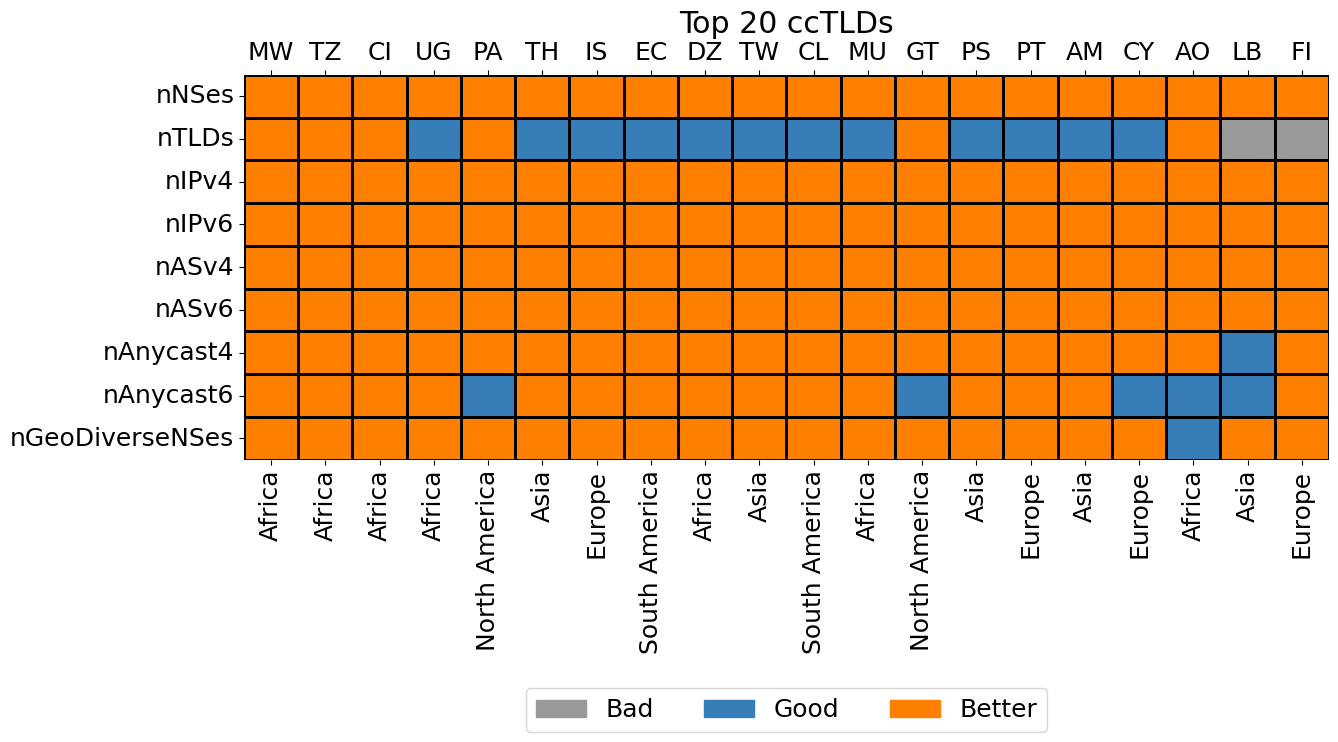

In [53]:
col_order = 'nNSes,nTLDs,nIPv4,nIPv6,nASv4,nASv6,nAnycast4,nAnycast6,nGeoDiverseNSes'.split(',')
col_order = col_order[::-1] # reverse

n_cc = 20

cc_list = maturity_score.sort_values(ascending=False).index.tolist()
cc_list = [cc for cc in cc_list if cc.lower() in cctld_to_continent.keys()]

data=maturity_df.drop(columns=['nRIRv4','nRIRv6']).loc[:,col_order]
data=data.applymap(lambda x:scale_to_score[x]).T
# fig,ax=plt.subplots(2,1,figsize=(14,15), sharey=True, gridspec_kw=dict(hspace=1))
fig,ax=plt.subplots(figsize=(14,5))
# fig.tight_layout()

color_scheme = threescale_cbcolors

plt.rcParams.update({'font.size': 18})

ax0_tw = ax.twiny()

# top
make_per_cc_heatmap(data.loc[data.index[::-1],cc_list[:n_cc]],ax=ax0_tw, make_fig=False)

ax.set_title(f'Top {n_cc} ccTLDs')

make_per_cc_heatmap(data.loc[data.index[::-1],cc_list[:n_cc]].rename(columns=lambda x:cctld_to_continent[x.lower()]),ax=ax, make_fig=False)

ax.set_xlabel('')
ax0_tw.set_xlabel(None)

bad_patch = mpatches.Patch(color=color_scheme[0], label='Bad')
good_patch = mpatches.Patch(color=color_scheme[1], label='Good')
better_patch = mpatches.Patch(color=color_scheme[2], label='Better')
ax0_tw.legend(handles=[bad_patch, good_patch, better_patch], bbox_to_anchor=(0.5,-0.65), ncol=3, loc='center')

plt.savefig('../figures/heatmap_top20cctld_per_metrics.pdf',bbox_inches = 'tight')
plt.show()
plt.close()

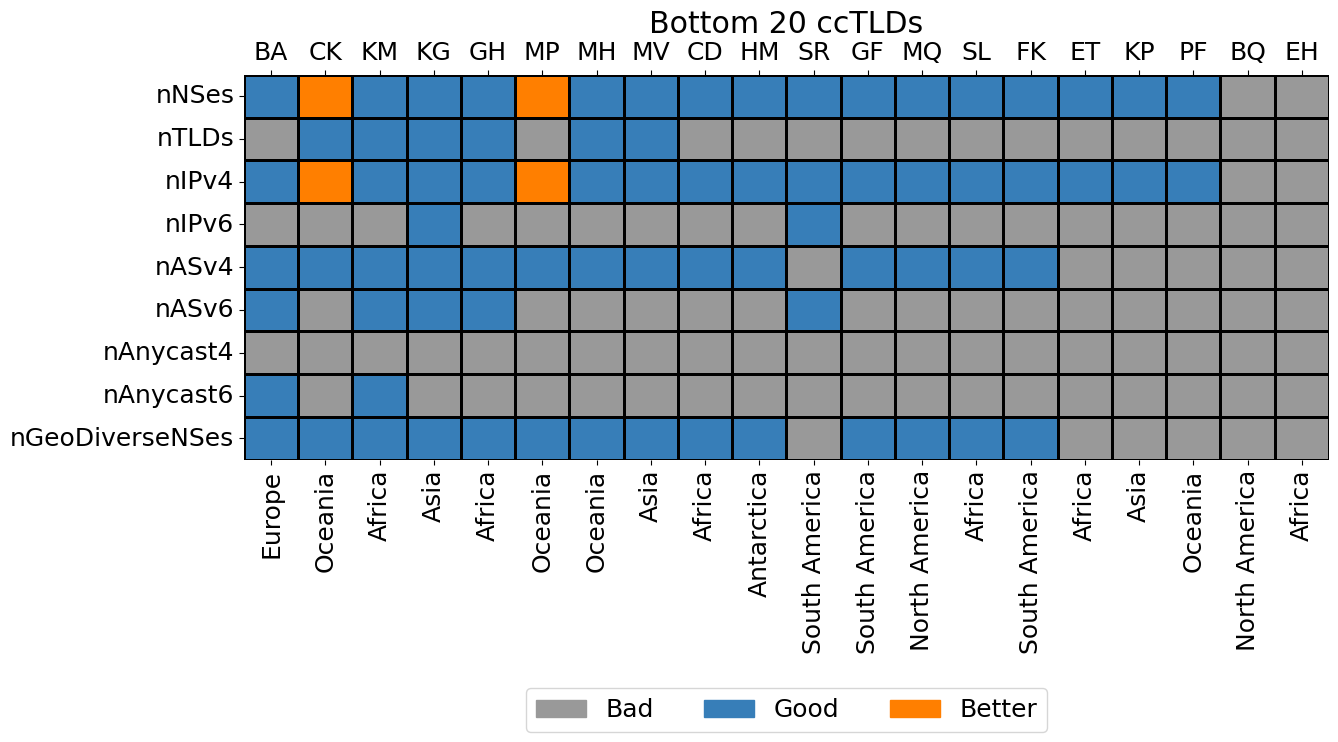

In [55]:
col_order = 'nNSes,nTLDs,nIPv4,nIPv6,nASv4,nASv6,nAnycast4,nAnycast6,nGeoDiverseNSes'.split(',')
col_order = col_order[::-1] # reverse

n_cc = 20

cc_list = maturity_score.sort_values(ascending=False).index.tolist()
cc_list = [cc for cc in cc_list if cc.lower() in cctld_to_continent.keys()]

data=maturity_df.drop(columns=['nRIRv4','nRIRv6']).loc[:,col_order]
data=data.applymap(lambda x:scale_to_score[x]).T
fig,ax=plt.subplots(figsize=(14,5))

# fig.tight_layout()

color_scheme = threescale_cbcolors

plt.rcParams.update({'font.size': 18})

ax1_tw = ax.twiny()

# bottom
make_per_cc_heatmap(data.loc[data.index[::-1],cc_list[-n_cc:]],ax=ax1_tw, make_fig=False)

ax.set_title(f'Bottom {n_cc} ccTLDs')

make_per_cc_heatmap(data.loc[data.index[::-1],cc_list[-n_cc:]].rename(columns=lambda x:cctld_to_continent[x.lower()]),ax=ax, make_fig=False)

ax.set_xlabel('')
ax1_tw.set_xlabel(None)

bad_patch = mpatches.Patch(color=color_scheme[0], label='Bad')
good_patch = mpatches.Patch(color=color_scheme[1], label='Good')
better_patch = mpatches.Patch(color=color_scheme[2], label='Better')
ax1_tw.legend(handles=[bad_patch, good_patch, better_patch], bbox_to_anchor=(0.5,-0.65), ncol=3, loc='center')

plt.savefig('../figures/heatmap_bottom20cctld_per_metrics.pdf',bbox_inches = 'tight')
plt.show()
plt.close()

In [145]:
def plot_zonemaster_module_tag(df, africa):
    tmp = df.copy()
    tmp.dropna(inplace=True)
    tmp['cc_iso3'] = tmp['cc'].apply(lambda x: pycountry.countries.get(alpha_2=x).alpha_3)
    tmp_tag = tmp[['cc_iso3','tag']].drop_duplicates()
    tmp_module = tmp[['cc_iso3','module']].drop_duplicates()
    tmp_level = tmp[['cc_iso3','level']].drop_duplicates()

    tmp_africa = africa.copy()
    tmp_africa.loc[:, 'tag'] = [ tmp_tag[tmp_tag['cc_iso3'] == x]['tag'].values[0]  if x in tmp_tag['cc_iso3'].tolist() else None for x in africa.iso_a3.tolist() ]
    tmp_africa.loc[:, 'module'] = [ tmp_module[tmp_module['cc_iso3'] == x]['module'].values[0]  if x in tmp_module['cc_iso3'].tolist() else None for x in africa.iso_a3.tolist() ]
    tmp_africa.loc[:, 'level'] = [ tmp_level[tmp_level['cc_iso3'] == x]['level'].values[0]  if x in tmp_level['cc_iso3'].tolist() else None for x in africa.iso_a3.tolist() ]

    tmp_africa['tag'] = tmp_africa['tag'].astype('category')
    tmp_africa['module'] = tmp_africa['module'].astype('category')
    tmp_africa['level'] = tmp_africa['level'].astype('category')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
    tmp_africa.plot(column='module',
            ax=ax1,
            legend = True,
            categorical=True,
            missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing data",
            },
            edgecolor="black",
    )
    
    tmp_africa.plot(column='tag',
            ax=ax2,
            legend = True,
            categorical=True,
            missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing data",
            },
            edgecolor="black",
    )

    ax1.set_title("")
    ax2.set_title("")
    ax1.set_ylabel("")
    ax2.set_ylabel("")
    ax1.axis('off')
    ax2.axis('off')
    leg1 = ax1.get_legend()
    leg1.set_bbox_to_anchor((.3,.5))
    leg2 = ax2.get_legend()
    leg2.set_bbox_to_anchor((.3,.65))
    ax1.text(.5,-.1,'(a) ZoneMaster Categories',horizontalalignment='center', transform=ax1.transAxes)
    ax2.text(.5,-.1,'(b) ZoneMaster Tests cases',horizontalalignment='center', transform=ax2.transAxes)
    prefix = ''
    if data_version == 'old':
        prefix = 'OLD_'
    plt.savefig(f'../figures/{prefix}afri_cctld_nameserver_zonemaster_results_map_legend_position.pdf')
    plt.show()
    plt.close()
    return tmp_africa

##### Sub regional repartition #####

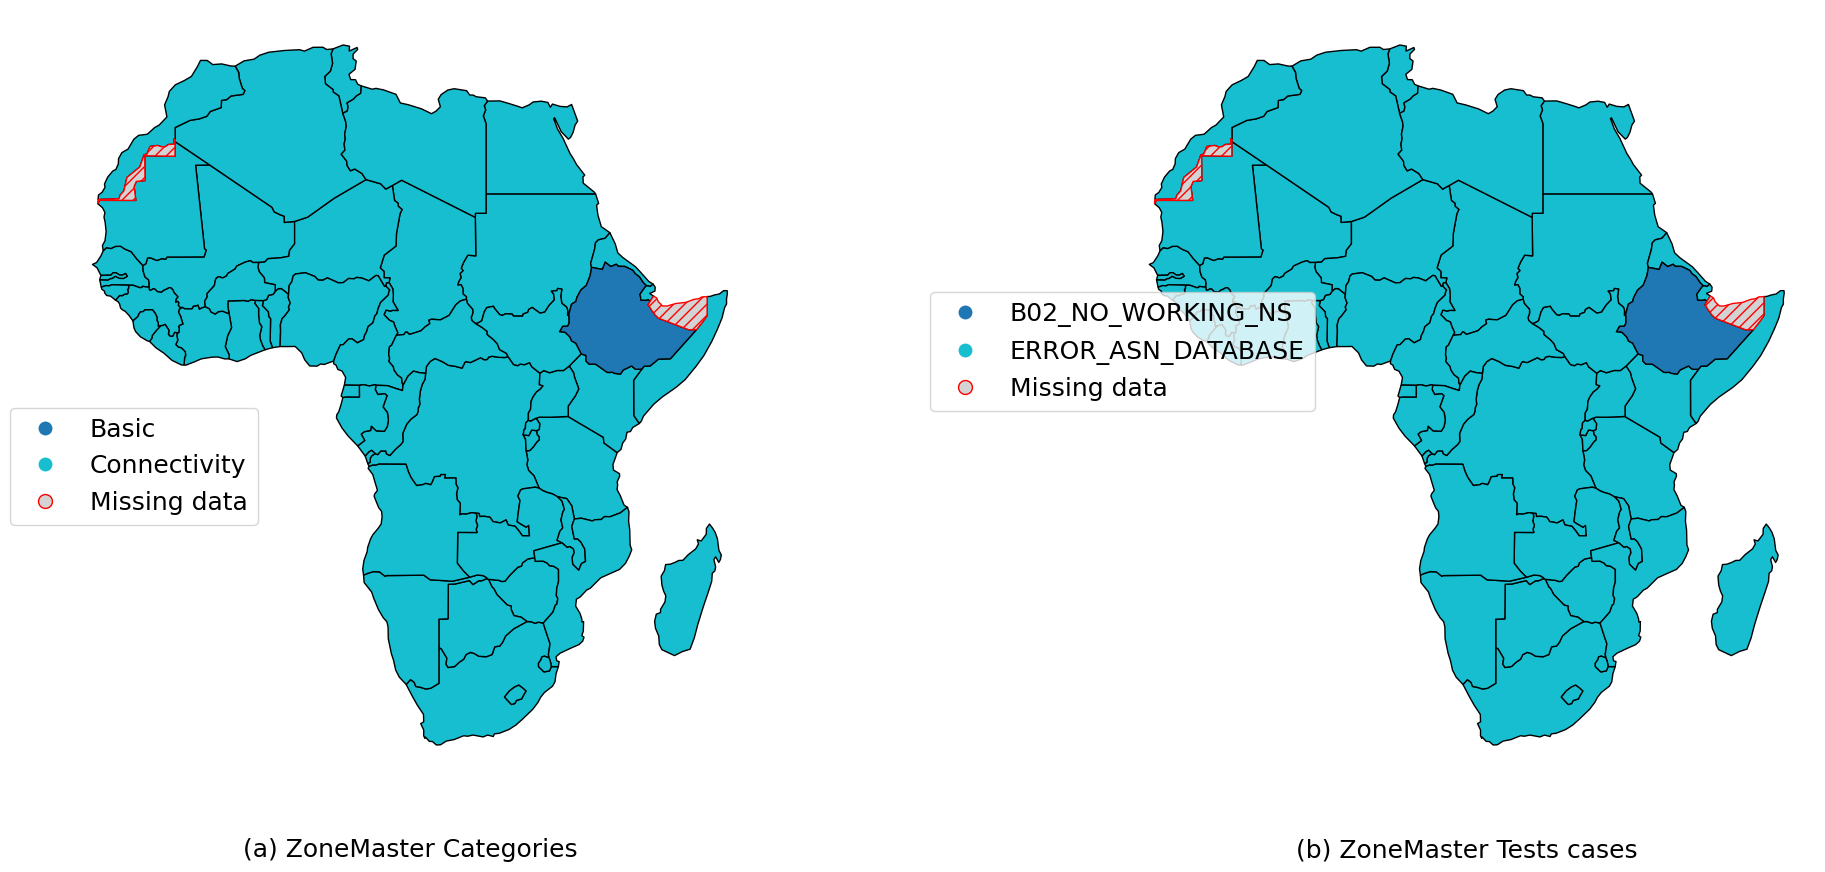

In [146]:
africa_zonemaster = plot_zonemaster_module_tag(zdf, africa)

##### Categories and tests cases #####

/tmp/ipykernel_2523452/3234197008.py:2: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.countplot(y='module', data=africa_zonemaster, ax=ax1, hue="level", order = africa_zonemaster['module'].value_counts().index, palette=sns.color_palette("RdBu"))


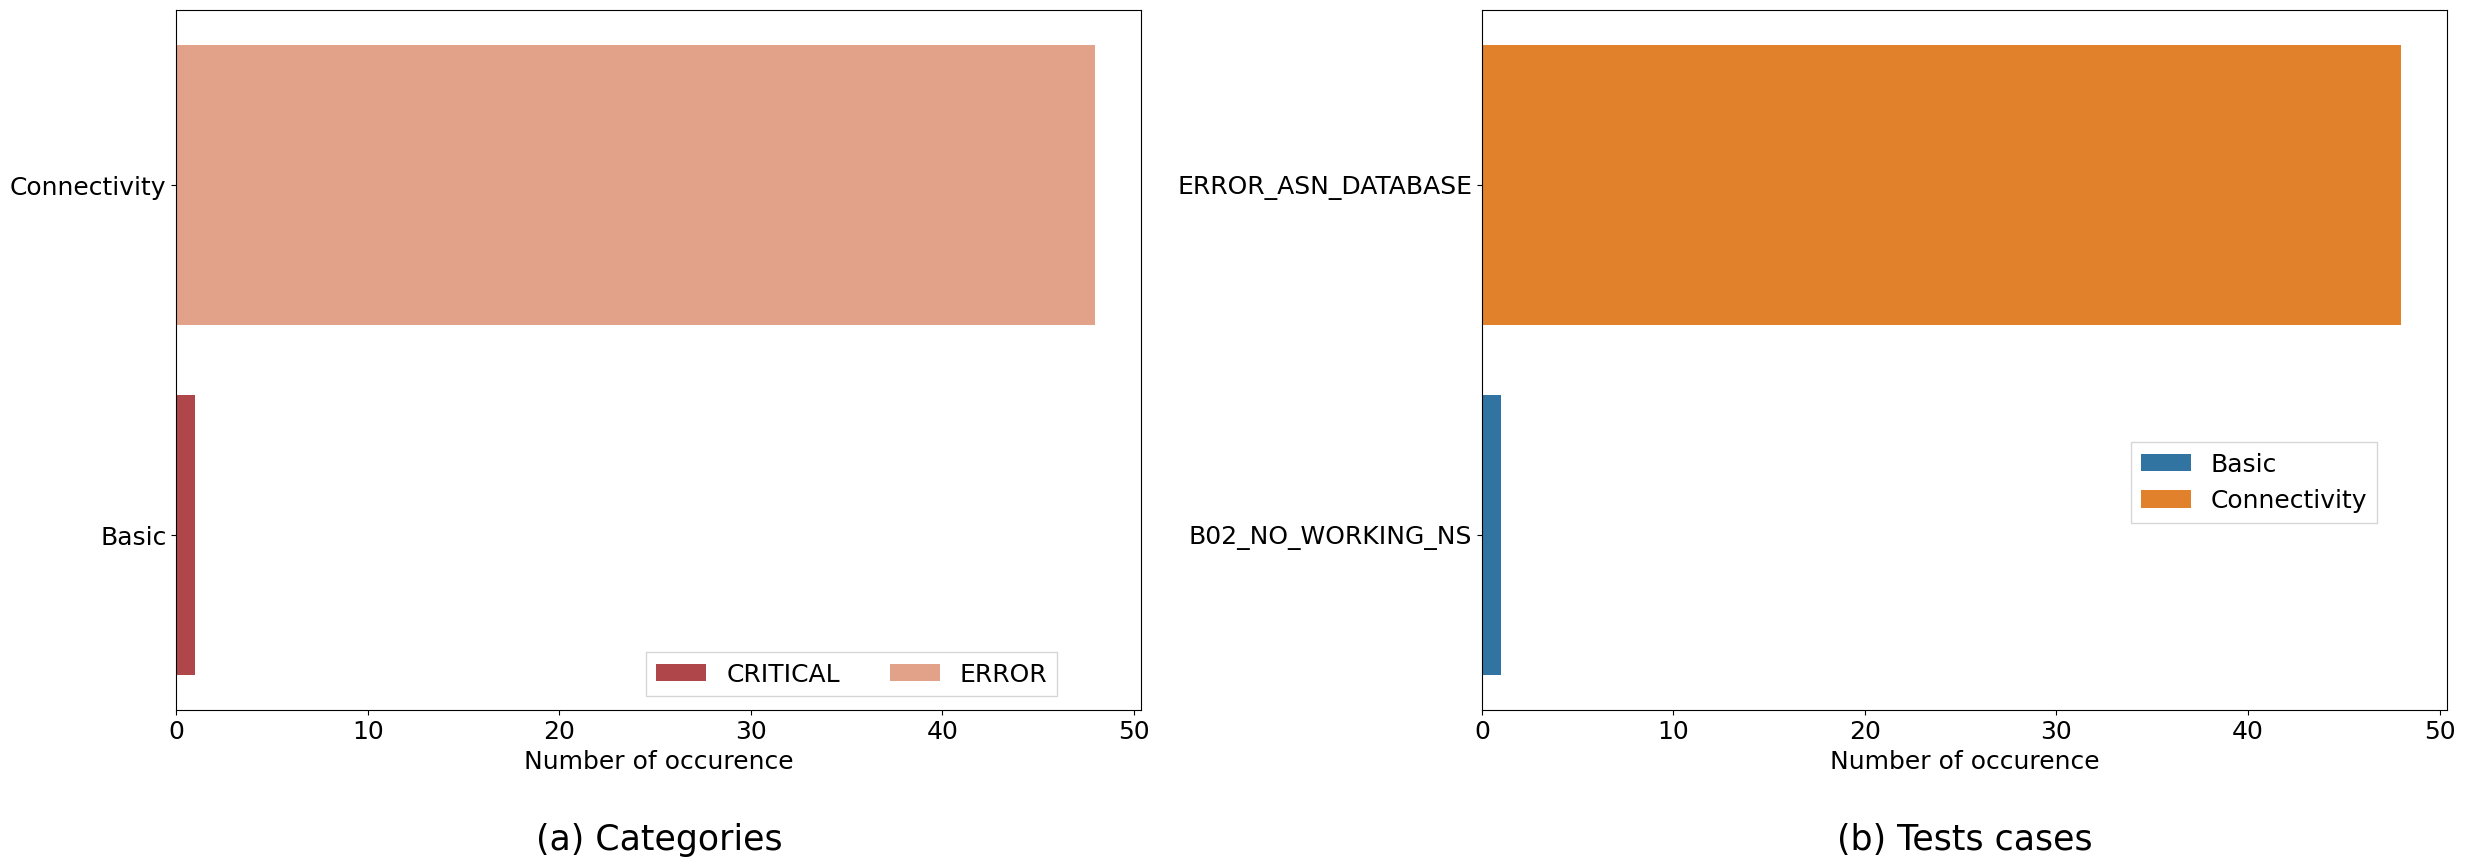

In [147]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(25,9))
sns.countplot(y='module', data=africa_zonemaster, ax=ax1, hue="level", order = africa_zonemaster['module'].value_counts().index, palette=sns.color_palette("RdBu"))
sns.countplot(y='tag', data=africa_zonemaster, ax=ax2, hue="module", order = africa_zonemaster['tag'].value_counts().index)
ax1.set_xlabel("Number of occurence")
ax2.set_ylabel("")
ax1.set_ylabel("")
ax2.set_xlabel("Number of occurence")

ax1.text(.5,-.2,'(a) Categories',horizontalalignment='center', transform=ax1.transAxes, fontsize=25)
ax2.text(.5,-.2,'(b) Tests cases',horizontalalignment='center', transform=ax2.transAxes, fontsize=25)
ax1.legend(loc='upper center', bbox_to_anchor=(0.7, .1), ncol=3, fancybox=False, shadow=False)
ax2.legend(loc='upper center', bbox_to_anchor=(0.8, .4), ncol=1, fancybox=False, shadow=False)

plt.tight_layout()
prefix = ''
if data_version == 'old':
    prefix = 'OLD_'
plt.savefig(f'../figures/{prefix}afri_cctld_nameserver_zonemaster_category_tests_results.pdf')
plt.show()
plt.close()

##### Zonemaster misconfigurations per test case #####

In [148]:
tests = zdataf['test'].unique()

In [149]:
countries_misconf = {}
for test in tests:
    countries_misconf[test] = list(zdataf[zdataf['test'] == test]['cc'].unique())

In [150]:
countries_misconf

{'NAMESERVER_IP_WITHOUT_REVERSE': ['AO',
  'CF',
  'CV',
  'DJ',
  'DZ',
  'EG',
  'GM',
  'GQ',
  'KE',
  'MA',
  'MR',
  'NA',
  'NE',
  'NG',
  'RW',
  'SL',
  'SN',
  'SZ',
  'TD',
  'TG',
  'ZW'],
 'CN01_NO_RESPONSE_UDP': ['AO',
  'BF',
  'BI',
  'BJ',
  'BW',
  'CD',
  'CF',
  'CG',
  'CI',
  'CM',
  'CV',
  'DJ',
  'DZ',
  'EG',
  'ER',
  'GA',
  'GH',
  'GM',
  'GN',
  'GQ',
  'GW',
  'KE',
  'KM',
  'LR',
  'LS',
  'LY',
  'MA',
  'MG',
  'ML',
  'MR',
  'MU',
  'MW',
  'MZ',
  'NA',
  'NE',
  'NG',
  'RW',
  'SC',
  'SD',
  'SL',
  'SN',
  'SO',
  'SS',
  'SZ',
  'TD',
  'TG',
  'TN',
  'TZ',
  'UG',
  'ZA',
  'ZM',
  'ZW'],
 'CN02_NO_RESPONSE_TCP': ['AO',
  'BF',
  'BI',
  'BJ',
  'BW',
  'CD',
  'CF',
  'CG',
  'CI',
  'CM',
  'CV',
  'DZ',
  'EG',
  'ER',
  'GA',
  'GH',
  'GM',
  'GN',
  'GQ',
  'GW',
  'KE',
  'KM',
  'LR',
  'LS',
  'LY',
  'MA',
  'MG',
  'ML',
  'MR',
  'MU',
  'MW',
  'MZ',
  'NA',
  'NE',
  'NG',
  'RW',
  'SC',
  'SD',
  'SL',
  'SN',
  'SO',
  'SS